# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import os
import glob
import matplotlib.pyplot as plt
import math
import cv2


%matplotlib inline

# Features

## Feature Functions

In [5]:
def resize(img,size):
    """size is a tuple"""
    """ returns resized images"""
    return cv2.resize(img,size)

def to_hsv(img):
    """return image in HSV space"""
    return cv2.cvtColor(img,cv2.COLOR_RGB2HSV)

def to_gray(img):
    """return image in gray space"""
    return cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

def sum_rgb(img):
    r_sum = g_sum = b_sum = rg_sum = count = 0
    for i in img:
        for j in i:
            if (j[0] > 20 and j[0] < 240 and j[1] > 20 and j[1] < 240 and j[2] > 20 and j[2] < 240):
                r_sum += j[0]
                g_sum += j[1]
                b_sum += j[2]
                rg_sum += j[0] - j[1]
                count += 1

    return [r_sum,g_sum,b_sum,rg_sum,count]

# Assuming img is a 3D NumPy array with shape (height, width, 3) representing an RGB image
def new_sum(img):
    # Create a boolean mask where each pixel is within the specified RGB range
    mask = (img[:, :, 0] > 20) & (img[:, :, 0] < 240) & \
           (img[:, :, 1] > 20) & (img[:, :, 1] < 240) & \
           (img[:, :, 2] > 20) & (img[:, :, 2] < 240)

    # Use the mask to filter the pixels within the specified RGB range
    filtered_pixels = img[mask]

    # Calculate the sums of the RGB values for the filtered pixels
    sum_r = np.sum(filtered_pixels[:, 0])
    sum_g = np.sum(filtered_pixels[:, 1])
    sum_b = np.sum(filtered_pixels[:, 2])
    sum_rg = sum_r - sum_g

    return [sum_r, sum_g, sum_b, sum_rg, np.count_nonzero(filtered_pixels[:, 0])]

def sum(arr):
    # """returns sum and no. of pixels between 20 and 240"""
    # sum = 0
    # count = 0
    # for i in arr:
    #     for j in i:
    #         if(j>20 and j<240): #only pixels whose value is between 20 and 240
    #             sum+=j
    #             count+=1

    #only pixels whose value is between 20 and 240
    arr = arr[arr>20]
    arr = arr[arr<240]

    return (arr.sum(), arr.size)

    # return (sum,count)

def pooling(image, pool_size, code, padding):
    """
    different codes for different pooling
    code min :min pooling
    code max :max pooling 
    code mean :mean pooling 
    code std :standard deviation pooling
    returns a image with padding operation and pooling operation
    """

    padded = arr = np.zeros((image.shape[0] + padding*2, 
                       image.shape[1] + padding*2))
    
    #  inserting image into zero array
    padded[int(padding):-int(padding), int(padding):-int(padding)] = image
    
    
    # print(f'original image size: {image.shape}')
    # print(f'padded image size: {padded.shape}')

    input_height, input_width = padded.shape
    pool_height, pool_width = pool_size

    # Calculate the output dimensions
    output_height = input_height - pool_height + 1
    output_width = input_width - pool_width + 1

    # Initialize the output data
    output_data = np.zeros((output_height, output_width))

    for i in range(output_height):
        for j in range(output_width):
            # Extract the region of interest (ROI)
            roi = padded[i : i + pool_height, j : j + pool_width]
            
            if code=='min':
                # Apply min pooling within the ROI
                output_data[i, j] = np.min(roi)

            if code=='max':
                # Apply max pooling within the ROI
                output_data[i, j] = np.max(roi)

            if code=='mean':
                # Apply mean pooling within the ROI
                output_data[i, j] = np.mean(roi)

            if code=='std':
                # Apply min pooling within the ROI
                output_data[i, j] = np.std(roi)


    # print(f'{code} pooled image size: {output_data.shape}')
    return output_data

## Calling Function

The image should be in RGB format

In [12]:
def feature(data):
    """Return all the 12 features as a numpy array"""
    uid,img,label = data
    img = resize(img,(250,250))

    #RGB SPACE
    sum_img = new_sum(img)  # NEW SUM FUNCTION
    count = sum_img.pop()
    mean_features = [i/count for i in sum_img]
    mean_r,mean_g,mean_b,mean_rg = mean_features
    # 4 features done in RGB SPACE

    
    #HSV SPACE
    hsv = to_hsv(img)
    h,s,v = cv2.split(hsv)
    _,h_counts = sum(h)
    h = h/h.max()
    nH = np.count_nonzero(h>0.95)
    HHR = nH/h_counts
    # HHR found

    
    #GRAY SPACE
    gray = to_gray(img)
    B_sum, B_size = sum(gray)
    B = B_sum/B_size # FOUND B

    #ENTROPY in gray space
    eq = cv2.equalizeHist(gray)
    unique, counts = np.unique(eq, return_counts=True)
    #only pixels whose value is between 20 and 240
    total_counts = counts[21:241].sum() 
    Ent = np.sum(np.array([-i*(i/total_counts)*math.log((i/total_counts),2) for i in counts[21:241]])) #Found Entropy

    #Calculating the 'G' features
    Ixy = gray
    min_Ixy = pooling(image=Ixy, pool_size=(3,3), code='min', padding=1)
    max_Ixy = pooling(image=Ixy, pool_size=(3,3), code='max', padding=1)
    mean_Ixy = pooling(image=Ixy, pool_size=(3,3), code='mean', padding=1)
    std_Ixy = pooling(image=Ixy, pool_size=(3,3), code='std', padding=1)
    
    g1 = Ixy - min_Ixy
    g2 = max_Ixy - Ixy
    g3 = Ixy - mean_Ixy
    g4 = std_Ixy
    g5 = Ixy
    
    G1 = sum(g1)[0]/sum(g1)[1]
    G2 = sum(g2)[0]/sum(g2)[1]
    G3 = sum(g3)[0]/sum(g3)[1]
    G4 = sum(g4)[0]/sum(g4)[1]
    G5 = sum(g5)[0]/sum(g5)[1]

    feature_all = [uid,mean_r,mean_g,mean_b,mean_rg,HHR,Ent,B,G1,G2,G3,G4,G5,label]
    return feature_all

# Right Nail Data

In [13]:
mask_right_nail_files = glob.glob("../../Field Data/Individual Anatomy/Galaxy M34/Right Fingernail_files/right_nail_segmask/SegmentationClass/*.png")
right_nail_path = "../../Field Data/Individual Anatomy/Galaxy M34/Right Fingernail_files/Images_right_fingernail\\"

In [14]:
right_nail_truth = pd.read_csv("annotations_right_nail.csv")
right_nail_truth.head(5)

,Annotated_Data,Avaiable ID,Hb Value,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,1709617374918.jpg,202403051,11.5,NaN,NaN,NaN,Average,11.563
1,1709617703730.jpg,202403052,11.6,NaN,NaN,NaN,NaN,NaN
2,1709618658975.jpg,202403056,11.1,NaN,NaN,NaN,NaN,NaN
3,1709619498294.jpg,202403058,12.1,NaN,NaN,NaN,NaN,NaN
4,1709620017738.jpg,202403059,12.2,NaN,NaN,NaN,NaN,NaN


## Dataset Creation

In [62]:
Total_Data = []
error_names = []

for mask_path in mask_right_nail_files:
    try:
        name = mask_path.split("\\")[-1].split(".")[0] + ".jpg"
        
        mask_bgr = cv2.imread(mask_path)
        img_bgr = cv2.imread(right_nail_path + name)
        mask = cv2.cvtColor(mask_bgr,cv2.COLOR_BGR2GRAY)
        img = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)
    
        roi = cv2.bitwise_and(img, img, mask = mask)
    
        uid = right_nail_truth[right_nail_truth['Annotated_Data'] == name]["Avaiable ID"].tolist()[0]
    
        label = right_nail_truth[right_nail_truth['Annotated_Data'] == name]["Hb Value"].tolist()[0]
    
        data_sent = [uid,roi,label]
    
        features = feature(data_sent)
    
        Total_Data.append(features)

    except Exception as e:
        error = [name,e]
        error_names.append(error)

## Errors

In [63]:
error_names

[['1709619498294.jpg', ZeroDivisionError('division by zero')],
 ['1709620997717.jpg', ZeroDivisionError('division by zero')],
 ['1709627557684.jpg', ZeroDivisionError('division by zero')],
 ['1709628983297.jpg', ZeroDivisionError('division by zero')],
 ['1709640736974.jpg', ZeroDivisionError('division by zero')],
 ['1709792080268.jpg', ZeroDivisionError('division by zero')],
 ['1709793881980.jpg', ZeroDivisionError('division by zero')],
 ['1709795076038.jpg', ZeroDivisionError('division by zero')],
 ['1709795639474.jpg', ZeroDivisionError('division by zero')],
 ['1709796036555.jpg', ZeroDivisionError('division by zero')],
 ['1709799457005.jpg', ZeroDivisionError('division by zero')],
 ['1709799956552.jpg', ZeroDivisionError('division by zero')],
 ['1709809698893.jpg', ZeroDivisionError('division by zero')]]

## Saving Data

In [64]:
cols = ['number','mean_r','mean_g','mean_b','mean_rg','HHR','Ent','B','G1','G2','G3','G4','G5','label']

complete_data = pd.DataFrame(Total_Data,columns=cols)

In [65]:
# complete_data.to_csv('right_nail_data_new.csv',index = False)

# Tongue Data

In [66]:
mask_tongue_files = glob.glob("../../Field Data/Individual Anatomy/Galaxy M34/Tongue_files/tongue_segmasks/SegmentationClass/*.png")
tongue_path = "../../Field Data/Individual Anatomy/Galaxy M34/Tongue_files/Images_tongue\\"

In [67]:
tongue_truth = pd.read_csv("annotations_tongue.csv")
tongue_truth.head(5)

,Annotated_Data,Avaiable ID,Hb Value,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,1709617694248.jpg,202403051,11.5,NaN,NaN,NaN,NaN
1,1709617844626.jpg,202403052,11.6,NaN,NaN,Average,11.556711
2,1709619191362.jpg,202403056,11.1,NaN,NaN,NaN,NaN
3,1709619874657.jpg,202403058,12.1,NaN,NaN,NaN,NaN
4,1709620272757.jpg,202403059,12.2,NaN,NaN,NaN,NaN


## Dataset Creation

In [70]:
Total_Data = []
error_names = []

for mask_path in mask_tongue_files:
    try:
        name = mask_path.split("\\")[-1].split(".")[0] + ".jpg"
        
        mask_bgr = cv2.imread(mask_path)
        img_bgr = cv2.imread(tongue_path + name)
        mask = cv2.cvtColor(mask_bgr,cv2.COLOR_BGR2GRAY)
        img = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)
    
        roi = cv2.bitwise_and(img, img, mask = mask)
    
        uid = tongue_truth[tongue_truth['Annotated_Data'] == name]["Avaiable ID"].tolist()[0]
    
        label = tongue_truth[tongue_truth['Annotated_Data'] == name]["Hb Value"].tolist()[0]
    
        data_sent = [uid,roi,label]
    
        features = feature(data_sent)
    
        Total_Data.append(features)

    except Exception as e:
        error = [name,e]
        error_names.append(error)

## Errors

In [71]:
error_names

[]

## Saving Data

In [72]:
cols = ['number','mean_r','mean_g','mean_b','mean_rg','HHR','Ent','B','G1','G2','G3','G4','G5','label']

complete_data = pd.DataFrame(Total_Data,columns=cols)

In [73]:
# complete_data.to_csv('tongue_data_new.csv',index = False)

# Left Palm Data

In [74]:
mask_left_palm_files = glob.glob("../../Field Data/Individual Anatomy/Galaxy M34/Left Palm_files/left_palm_segmasks/SegmentationClass/*.png")
left_palm_path = "../../Field Data/Individual Anatomy/Galaxy M34/Left Palm_files/Images_left_palm\\"

In [75]:
left_palm_truth = pd.read_csv("annotations_left_palm.csv")
left_palm_truth.head(5)

,Annotated_Data,Avaiable ID,Hb Value,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,1709617238375.jpg,202403051,11.5,NaN,NaN,Average,11.53193
1,1709617534838.jpg,202403052,11.6,NaN,NaN,NaN,NaN
2,1709618528581.jpg,202403056,11.1,NaN,NaN,NaN,NaN
3,1709619358067.jpg,202403058,12.1,NaN,NaN,NaN,NaN
4,1709619811692.jpg,202403059,12.2,NaN,NaN,NaN,NaN


## Dataset Creation

In [76]:
Total_Data = []
error_names = []

for mask_path in mask_left_palm_files:
    try:        
        name = mask_path.split("\\")[-1].split(".")[0] + ".jpg"
        
        mask_bgr = cv2.imread(mask_path)
        img_bgr = cv2.imread(left_palm_path + name)
        mask = cv2.cvtColor(mask_bgr,cv2.COLOR_BGR2GRAY)
        img = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)
    
        roi = cv2.bitwise_and(img, img, mask = mask)
    
        uid = left_palm_truth[left_palm_truth['Annotated_Data'] == name]["Avaiable ID"].tolist()[0]
    
        label = left_palm_truth[left_palm_truth['Annotated_Data'] == name]["Hb Value"].tolist()[0]
    
        data_sent = [uid,roi,label]
    
        features = feature(data_sent)
    
        Total_Data.append(features)
    
    except Exception as e:
        error = [name,e]
        error_names.append(error)

## Errors

In [77]:
error_names

[['1709620330090.jpg', ZeroDivisionError('division by zero')],
 ['1709622111640.jpg', ZeroDivisionError('division by zero')],
 ['1709637220943.jpg', ZeroDivisionError('division by zero')],
 ['1709723476667.jpg', ZeroDivisionError('division by zero')],
 ['1709795520401.jpg', ZeroDivisionError('division by zero')]]

## Saving Data

In [78]:
cols = ['number','mean_r','mean_g','mean_b','mean_rg','HHR','Ent','B','G1','G2','G3','G4','G5','label']

complete_data = pd.DataFrame(Total_Data,columns=cols)

In [79]:
# complete_data.to_csv('left_palm_data_new.csv',index = False)

# Error Data Check

In [46]:
mask = cv2.imread("../../Field Data/Individual Anatomy/Galaxy M34/Right Fingernail_files/right_nail_segmask/SegmentationClass/1709619498294.png")
img = cv2.imread("../../Field Data/Individual Anatomy/Galaxy M34/Right Fingernail_files/Images_right_fingernail\\1709619498294.jpg")

In [47]:
mask = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

In [48]:
roi = cv2.bitwise_and(img, img, mask = mask)

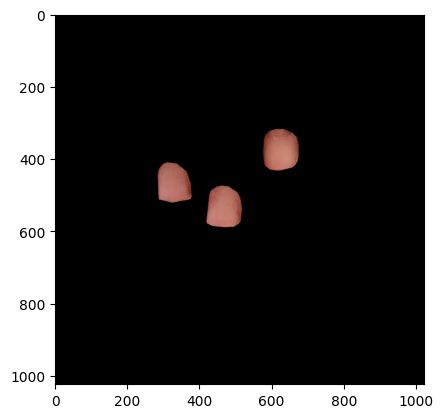

In [49]:
plt.imshow(roi)

In [51]:
roi = resize(roi,(250,250))

In [53]:
#HSV SPACE
hsv = to_hsv(roi)
h,s,v = cv2.split(hsv)
_,h_counts = sum(h)
h = h/h.max()
nH = np.count_nonzero(h>0.95)
HHR = nH/h_counts
# HHR found

ZeroDivisionError: division by zero

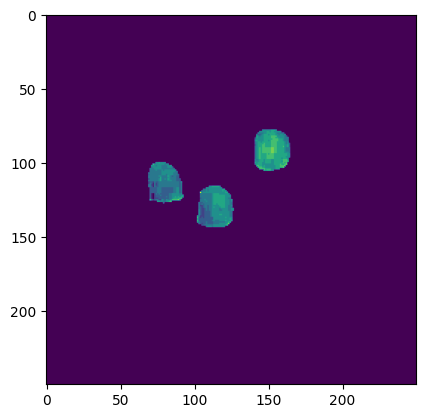

In [56]:
h,s,v = cv2.split(hsv)
plt.imshow(h)

In [61]:
np.unique(h)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10], dtype=uint8)